# 메서드 정의

### L1: URL, header, API KEY, raw data

In [3]:
from jwt import JWT, jwk
import hashlib
import requests
import uuid

from urllib.parse import urlencode, unquote
import urllib.parse as url_parser

import json
import pandas as pd

from collections import namedtuple

from typing import Literal, Dict

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from time import sleep

UrlComponents = namedtuple(typename="UrlComponents", field_names=["scheme", "netloc", "url", "params", "query", "fragment"])

#### Duration class

In [4]:
class Duration():
    '''
    BTEM의 날짜 및 시간 클래스입니다.
    
    생성자로 전달되는 interval 정보가 반영된 iterator가 내장되어 iterable 조건을 만족합니다.

    
    예제
    ----

    >> duration = Duration(start="2020-01-01T00:00", interval="MONTH", end="2021-01-01T23:59")

    >> for date in duration:

    ... print(date)

    ...
    2020-01-01 00:00:00
    2020-02-01 00:00:00
    2020-03-01 00:00:00
    2020-04-01 00:00:00
    2020-05-01 00:00:00
    2020-06-01 00:00:00
    2020-07-01 00:00:00
    2020-08-01 00:00:00
    2020-09-01 00:00:00
    2020-10-01 00:00:00
    2020-11-01 00:00:00
    2020-12-01 00:00:00
    2021-01-01 00:00:00
    '''


    def __init__(self, start: str, end: str, batch_size: int=1, interval: Literal["DAY", "HOUR", "MONTH"]="DAY", _format: str="%Y-%m-%dT%H:%M") -> None:
        '''
        Args
        ----
        start: str, 시작 일시를 표현한 문자열
        end: str, 종료 일시를 표현한 문자열
        batch_size: int=1, (iterable 객체로 사용 시) 배치 크기
        interval: Literal["DAY", "HOUR", "MONTH"]="DAY", 시점과 종점 간 간격을 지정
        _format: str="%Y%m%d", start와 end의 표현 형식

        Examples
        --------
        1일 간격으로 2010년 1월 1일부터 2020년 1월 1일까지를 나타내는 Duration
        >> Duration(start="20100101", end="20200101", interval="DAY")
        '''

        if batch_size <= 0:
            raise ValueError("batch size must over 0.")

        # datetime 객체로 변환
        start_dt = datetime.strptime(start, _format)
        end_dt = datetime.strptime(end, _format)

        # start, end 간의 시간 순서 유효성 검사
        if (end_dt - start_dt) < timedelta(days=0, hours=0, seconds=0):
            raise ValueError(f"start date must earier than end date, got start: {start}, end: {end}")


        # 간격 지정
        if interval == "MONTH":
            self.period_id = "1MTH"
            interval_dt = relativedelta(months=1)
        elif interval == "HOUR":
            self.period_id = "1HRS"
            interval_dt = timedelta(hours=1)
        else:
            self.period_id = "1DAY"
            interval_dt = timedelta(days=1)

        # 객체 멤버에 저장
        self.start = start_dt
        self.end = end_dt
        self.interval = interval_dt
        self.current = start_dt
        self.batch_size = batch_size


    def strftime(self, timezone=False) -> Dict[str, str]:
        start, end = self.start.isoformat().split('.')[0], self.end.isoformat().split('.')[0],

        if timezone:
            start += "+09:00"
            end += "+09:00"        

        result = {"start": start, "end": end}
        return result

    def __iter__(self):
        return self

    def __next__(self):
        if self. current < self.end:
            result = self.current
            self.current += (self.interval * self.batch_size)
            return result
        
        self.current = self.start
        raise StopIteration



In [5]:
duration = Duration(start="2020-01-01T00:00", interval="MONTH", end="2021-01-01T23:59")
for date in duration:
    print(date)

2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00


#### URL Generator

In [6]:
def generate_url(source: Literal["upbit", "coinapi"], api_name: Literal["show_account", "order_available", "make_order", "market_code", "BTC_candle"], query: dict|None=None) -> str:
    """
    API 호출을 위한 URL을 생성하는 메서드입니다.

    generates URL for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.

    api_name : Literal["show_account", "order_available", "make_order", "market_code", "BTC_candle"]
        호출할 API의 종류를 지정합니다.

    query : dict|None=None
        호출할 API에 들어갈 질의를 지정합니다.
    
    
    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.


    Returns
    -------
    result_url
        생성된 URL 문자열    
    """


    # URL 자료 구조 정의
    URL_SOURCES = {
        "upbit": "api.upbit.com",
        "coinapi": "rest.coinapi.io",
    }

    URL_PATHS = {
        "show_account": "v1/accounts",
        "order_available": "v1/orders/chance",
        "make_order": "v1/orders",
        "market_code": "v1/orders/chance",
        "BTC_candle": "v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history",

    }

    SUPPORTED_API_NAMES = URL_PATHS.keys()
    SUPPORTED_SOURCES = URL_SOURCES.keys()

    # 파라미터 검증
    if source not in SUPPORTED_SOURCES:
        raise ValueError(f'source must be "upbit" or "coinapi". input is {source}')
    
    if api_name not in SUPPORTED_API_NAMES:
        raise ValueError(f'api_name {source} not found in supported api_name.')
    
    query = "" if query is None else url_parser.urlencode(query)

    url_params = UrlComponents(
        scheme = "https",
        netloc = URL_SOURCES[source],
        url = URL_PATHS[api_name],
        params = "",
        query = query,
        fragment = "",
    )

    result_url = str(url_parser.urlunparse(url_params))
    return result_url


#### Query Generator

In [47]:
def generate_query(**params: str) -> Dict[str, str]:
    '''
    period_id:
        Second	1SEC, 2SEC, 3SEC, 4SEC, 5SEC, 6SEC, 10SEC, 15SEC, 20SEC, 30SEC
        Minute	1MIN, 2MIN, 3MIN, 4MIN, 5MIN, 6MIN, 10MIN, 15MIN, 20MIN, 30MIN
        Hour	1HRS, 2HRS, 3HRS, 4HRS, 6HRS, 8HRS, 12HRS
        Day	1DAY, 2DAY, 3DAY, 5DAY, 7DAY, 10DAY
        Month	1MTH, 2MTH, 3MTH, 4MTH, 6MTH
        Year	1YRS, 2YRS, 3YRS, 4YRS, 5YRS
    '''

    query = {i:params[i] for i in params}    
    return query


#### API Key Generator

In [48]:
def get_api_key(source: Literal["upbit", "coinapi"]) -> tuple[str, jwk.OctetJWK]|str:
    """
    API 호출을 위한 key를 제공하는 메서드입니다.

    provides API keys for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.


    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.

    FileNotFoundError
        원본 key 파일(./keys.json)을 찾을 수 없을 때 발생합니다.
        
    Returns
    -------
    access_key: str
        source="coinapi"인 경우 제공되는 access key입니다.
    
    Tuple[access_key: str, jwk_secret: jwk]
        source="upbit"인 경우 제공되는 (access key, secret token)입니다.
    """


    access_key, secret_key, jwk_secret = "", "", None

    with open("./keys.json") as f:
        keys = json.load(f)

        if source == "upbit":
            access_key = keys["upbit_access"]
            secret_key = keys["upbit_secret"].encode("utf8")

        elif source == "coinapi":
            access_key = keys["coinapi_access"]

    if source == "upbit":
        jwk_secret = jwk.OctetJWK(key=secret_key)
        return (access_key, jwk_secret)
    
    else:
        return access_key

#### header Generator

In [49]:
def generate_header(source: Literal["upbit", "coinapi"], payload: dict|None=None):
    """
    API 호출을 위한 header를 생성하는 메서드입니다.

    generates header for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.


    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.

        
    Returns
    -------
    header : dict
        요청 정보가 담겨 있는 dictionary입니다.
    """


    header = {}

    if source == "upbit":
        UPBIT_ACCESS_KEY, UPBIT_SECRET_JWK = get_api_key(source)
        payload["access_key"] = UPBIT_ACCESS_KEY

        jwt_token = JWT().encode(payload, key=UPBIT_SECRET_JWK)

        authorization = 'Bearer {}'.format(jwt_token)
        header = { 'Authorization': authorization }
    
    elif source == "coinapi":
        header = {'X-CoinAPI-Key' : get_api_key(source)}

    return header


#### 비트코인 캔들 데이터

In [187]:
def get_bitcoin_candle(duration: Duration) -> pd.DataFrame:
    '''
    비트코인 캔들 데이터(BTC-USD, coinapi)를 가져옵니다.
    Parameters
    ----------
        duration: Duration 객체


    Raises
    ------

        
    Returns
    -------
        pd.DataFrame: 캔들 데이터를 담고 있는 데이터프레임
    '''

    # 한 번에 들고 올 데이터 수
    BATCH_SIZE: int = duration.batch_size

    # request 준비
    header = generate_header(source="coinapi")
    start_date = duration.start.isoformat().split('.')[0] + "+09:00"
    end_date = (duration.end + duration.interval).isoformat().split('.')[0] + "+09:00"
    period_id = duration.period_id


    # 테스트 겸 데이터 헤더 가져오기
    test_url = generate_url(source="coinapi", api_name="BTC_candle", query={"period_id": period_id, "time_start": start_date, "time_end": end_date, "include_empty_items": "true", "limit": BATCH_SIZE})
    test_response = requests.get(test_url, headers=header)
    test_resp_json = test_response.json()

    result_json = {i:[] for i in test_resp_json[0].keys()}
    
    # 본 데이터 수집
    for date in duration:
        # 날짜 문자열 생성
        current = date
        end = min((date + (duration.interval * BATCH_SIZE)), duration.end - duration.interval)
        current_date, end_date = current.isoformat().split('.')[0] + "+09:00", end.isoformat().split('.')[0] + "+09:00"

        # URL 생성
        url = generate_url(source="coinapi", api_name="BTC_candle", query={"period_id": period_id, "time_start": current_date, "time_end": end_date, "include_empty_items": "true", "limit": BATCH_SIZE})

        # 데이터 변환
        response = requests.get(url, headers=header)
        resp_json = response.json()

        for i in resp_json:
            for key in result_json.keys():
                if key in i.keys():
                    result_json[key].append(i[key])
                    continue

                # null data
                result_json[key].append(None)


    return pd.DataFrame(result_json)


In [188]:
candle = get_bitcoin_candle(Duration(start="2023-01-01T00:00", end="2023-07-01T23:59", interval="DAY", batch_size=50))
candle

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-01T00:00:00.0000000Z,2023-01-02T00:00:00.0000000Z,2023-01-01T00:00:30.1080000Z,2023-01-01T23:59:33.1230000Z,16530.0,16622.0,16496.0,16615.0,473.832738,11301
1,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615.0,16782.0,16552.0,16673.0,1046.658437,9780
2,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668.0,16766.0,16605.0,16670.0,1388.071966,11861
3,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673.0,16984.0,16652.0,16849.0,2038.030123,15672
4,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847.0,16871.0,16755.0,16826.0,1129.003529,10216
...,...,...,...,...,...,...,...,...,...,...
176,2023-06-26T00:00:00.0000000Z,2023-06-27T00:00:00.0000000Z,2023-06-26T00:00:25.8720000Z,2023-06-26T23:59:43.7090000Z,30480.0,30657.0,29941.0,30274.0,2059.054649,18547
177,2023-06-27T00:00:00.0000000Z,2023-06-28T00:00:00.0000000Z,2023-06-27T00:00:10.2770000Z,2023-06-27T23:59:44.4950000Z,30278.0,31025.0,30235.0,30696.0,2082.970505,16773
178,2023-06-28T00:00:00.0000000Z,2023-06-29T00:00:00.0000000Z,2023-06-28T00:00:02.6050000Z,2023-06-28T23:58:38.6990000Z,30697.0,30712.0,29868.0,30079.0,1867.545665,18493
179,2023-06-29T00:00:00.0000000Z,2023-06-30T00:00:00.0000000Z,2023-06-29T00:00:09.1210000Z,2023-06-29T23:59:50.6220000Z,30078.0,30825.0,30041.0,30444.0,1923.803262,18193


#### 비트코인 CME 선물 데이터

In [16]:
def get_bitcoin_cme_feature() -> pd.DataFrame:
    return pd.DataFrame()

### L2: 데이터 핸들러: Preprocess, python script

In [189]:
duration = Duration(start="2023-01-01T00:00", end="2023-07-01T23:59", interval="DAY", batch_size=50)
numeric_datas = get_bitcoin_candle(duration=duration)

In [191]:
from lib.preprocess import Preprocess

prep = Preprocess(data=numeric_datas, categorial_threshold=len(numeric_datas) + 1)
prep.remove_null(method="backfill", inplace=True)

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-01T00:00:00.0000000Z,2023-01-02T00:00:00.0000000Z,2023-01-01T00:00:30.1080000Z,2023-01-01T23:59:33.1230000Z,16530.0,16622.0,16496.0,16615.0,473.832738,11301
1,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615.0,16782.0,16552.0,16673.0,1046.658437,9780
2,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668.0,16766.0,16605.0,16670.0,1388.071966,11861
3,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673.0,16984.0,16652.0,16849.0,2038.030123,15672
4,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847.0,16871.0,16755.0,16826.0,1129.003529,10216
...,...,...,...,...,...,...,...,...,...,...
176,2023-06-26T00:00:00.0000000Z,2023-06-27T00:00:00.0000000Z,2023-06-26T00:00:25.8720000Z,2023-06-26T23:59:43.7090000Z,30480.0,30657.0,29941.0,30274.0,2059.054649,18547
177,2023-06-27T00:00:00.0000000Z,2023-06-28T00:00:00.0000000Z,2023-06-27T00:00:10.2770000Z,2023-06-27T23:59:44.4950000Z,30278.0,31025.0,30235.0,30696.0,2082.970505,16773
178,2023-06-28T00:00:00.0000000Z,2023-06-29T00:00:00.0000000Z,2023-06-28T00:00:02.6050000Z,2023-06-28T23:58:38.6990000Z,30697.0,30712.0,29868.0,30079.0,1867.545665,18493
179,2023-06-29T00:00:00.0000000Z,2023-06-30T00:00:00.0000000Z,2023-06-29T00:00:09.1210000Z,2023-06-29T23:59:50.6220000Z,30078.0,30825.0,30041.0,30444.0,1923.803262,18193


In [194]:
def MAL_model(numeric_data: pd.DataFrame):
    prices = ["price_open", "price_high", "price_low", "price_close"]
    numeric_data = prep.data

    for i in [5, 15, 30]:
        for price in prices:
            numeric_data[price + "_MAL_" + str(i)] = numeric_data[price].rolling(window=i, min_periods=i).mean()


<Axes: >

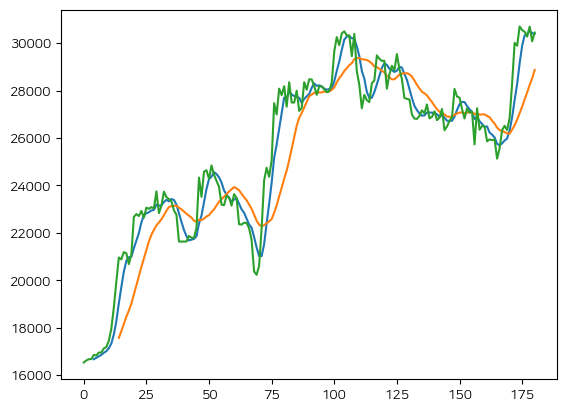

In [195]:
MAL_model(numeric_datas)

numeric_data["price_open_MAL_5"].plot()
numeric_data["price_open_MAL_15"].plot()
numeric_data["price_open"].plot()

### L3: 모델: sklearn, pytorch

### L4: 정보 취합, 규칙에 따른 트레이딩: python script

# RAW_METHOD

## FINANCE_DATA_READER

### 비트코인 CME 선물 가격

In [22]:
import FinanceDataReader as fdr

df = fdr.DataReader("BTC", "2023")
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,90.591003,90.618797,90.570000,90.618797,90.618797,1715.0
2023-01-04,90.879204,90.879204,90.879204,90.879204,90.879204,103.0
2023-01-05,90.751404,90.751404,90.751404,90.751404,90.751404,11.0
2023-01-06,90.919998,91.408302,90.919998,91.408302,91.408302,11299.0
2023-01-09,91.429001,91.599998,91.429001,91.599998,91.599998,3790.0
...,...,...,...,...,...,...
2023-06-14,91.459999,91.459999,91.459999,91.459999,91.459999,179.0
2023-06-15,91.824997,91.824997,91.824997,91.824997,91.824997,47.0
2023-06-16,91.614998,91.614998,91.614998,91.614998,91.614998,49.0


# TEST

In [1]:
from DataFetcher.DataFetcher import DataFetcher
from DataFetcher.Duration import Duration

dataFetcher = DataFetcher()

duration = Duration(start="2023-07-01T00:00", end="2023-07-29T12:00", batch_size=100_000, interval="HOUR")

bitcoin_candle = dataFetcher.get_bitcoin_candle(duration=duration)


fetching 2023-07-01T00:00:00+09:00 ~ 2023-07-29T12:00:00+09:00...

In [2]:
bitcoin_candle

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-06-30T15:00:00.0000000Z,2023-06-30T16:00:00.0000000Z,2023-06-30T15:00:01.0770000Z,2023-06-30T15:59:59.4990000Z,30066.0,30195.0,29992.0,30066.0,100.104178,1487
1,2023-06-30T16:00:00.0000000Z,2023-06-30T17:00:00.0000000Z,2023-06-30T16:00:02.2950000Z,2023-06-30T16:59:52.5360000Z,30066.0,30494.0,29925.0,30393.0,326.366499,2626
2,2023-06-30T17:00:00.0000000Z,2023-06-30T18:00:00.0000000Z,2023-06-30T17:00:10.9080000Z,2023-06-30T17:59:57.3630000Z,30393.0,30701.0,30375.0,30431.0,234.138858,1373
3,2023-06-30T18:00:00.0000000Z,2023-06-30T19:00:00.0000000Z,2023-06-30T18:00:01.7440000Z,2023-06-30T18:59:50.4580000Z,30437.0,30519.0,30285.0,30346.0,186.477398,1139
4,2023-06-30T19:00:00.0000000Z,2023-06-30T20:00:00.0000000Z,2023-06-30T19:00:00.9320000Z,2023-06-30T19:59:48.9370000Z,30352.0,30469.0,30323.0,30368.0,41.873237,660
...,...,...,...,...,...,...,...,...,...,...
679,2023-07-28T22:00:00.0000000Z,2023-07-28T23:00:00.0000000Z,2023-07-28T22:00:36.7150000Z,2023-07-28T22:59:47.1820000Z,29309.0,29317.0,29294.0,29295.0,4.770405,236
680,2023-07-28T23:00:00.0000000Z,2023-07-29T00:00:00.0000000Z,2023-07-28T23:00:50.1330000Z,2023-07-28T23:59:59.0390000Z,29295.0,29325.0,29295.0,29317.0,3.804100,204
681,2023-07-29T00:00:00.0000000Z,2023-07-29T01:00:00.0000000Z,2023-07-29T00:00:03.9510000Z,2023-07-29T00:59:59.0660000Z,29316.0,29348.0,29296.0,29325.0,88.304105,421
682,2023-07-29T01:00:00.0000000Z,2023-07-29T02:00:00.0000000Z,2023-07-29T01:00:04.2640000Z,2023-07-29T01:59:22.6990000Z,29325.0,29373.0,29324.0,29373.0,8.370918,393


In [3]:
data = bitcoin_candle.drop(["time_period_end", "time_open", "time_close", "price_open", "price_high", "price_low"], axis=1)

In [4]:
from models.MAL import MAL_model

model = MAL_model(data=data, duration=duration, timestamp_label="time_period_start")

In [5]:
model.add_mal(inplace=True)

,time_period_start,price_close,volume_traded,trades_count,MAL_5DAY,MAL_10DAY
0,2023-06-30T15:00:00.0000000Z,30066.0,100.104178,1487,NaN,NaN
1,2023-06-30T16:00:00.0000000Z,30393.0,326.366499,2626,NaN,NaN
2,2023-06-30T17:00:00.0000000Z,30431.0,234.138858,1373,NaN,NaN
3,2023-06-30T18:00:00.0000000Z,30346.0,186.477398,1139,NaN,NaN
4,2023-06-30T19:00:00.0000000Z,30368.0,41.873237,660,NaN,NaN
...,...,...,...,...,...,...
679,2023-07-28T22:00:00.0000000Z,29295.0,4.770405,236,29301.908333,29617.700000
680,2023-07-28T23:00:00.0000000Z,29317.0,3.804100,204,29295.508333,29615.404167
681,2023-07-29T00:00:00.0000000Z,29325.0,88.304105,421,29289.791667,29612.325000
682,2023-07-29T01:00:00.0000000Z,29373.0,8.370918,393,29285.283333,29609.654167


In [7]:
model.predict(MAL_long="MAL_10DAY", cross_duration=10)

False

In [77]:
from typing import Iterable
import pandas as pd
from datetime import timedelta
from dateutil.parser import isoparse


def add_mal(data:pd.DataFrame, duration: Duration, days: Iterable[int] = [5, 10, 60, 120, 240], target: str="price_close"):
    interval = duration.interval

    # 간격이 1시간
    if interval == timedelta(hours=1):
        days_weight = 24

    elif interval == timedelta(days=1):
        days_weight = 1

    else:
        raise ValueError("데이터셋의 시간 단위가 1HOUR, 1DAY인 경우에만 사용할 수 있습니다.")
    
    # 최대 간격 구하기
    max_interval = duration.end - duration.start
    days = [day for day in days if timedelta(days=day) < max_interval]

    if len(days) == 0:
        raise ValueError("최소 5일 동안의 데이터가 있어야 이동평균선을 구할 수 있습니다.")

    # 이동평균선 구하기
    for day in days:
        data[f"MAL_{day}DAY"] = data["price_close"].rolling(window=day * days_weight).mean()
    
    return data
        

In [78]:
import pandas as pd

data = bitcoin_candle.drop(["time_period_end", "time_open", "time_close", "price_open", "price_high", "price_low"], axis=1)

#### 이동평균 구하기

In [79]:
duration.interval

datetime.timedelta(seconds=3600)

In [81]:
data_mal = add_mal(data=data, duration=duration)

In [85]:
data["price_close"].rolling(window=24).mean()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
679    29265.208333
680    29269.291667
681    29271.291667
682    29276.166667
683    29282.500000
Name: price_close, Length: 684, dtype: float64

<Axes: >

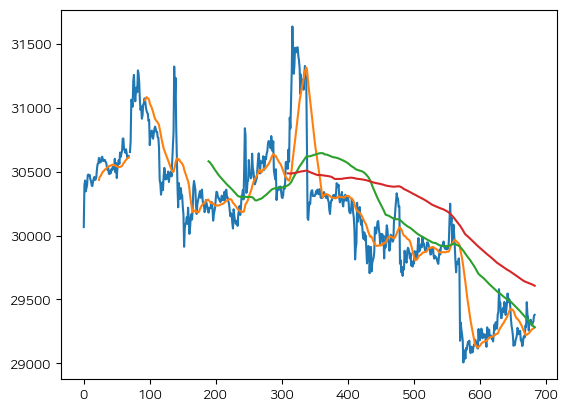

In [87]:
data_mal["price_close"].plot()
data["price_close"].rolling(window=24).mean().plot()
data_mal["MAL_5DAY"].plot()
data_mal["MAL_10DAY"].plot()

In [46]:
data

,time_period_start,price_close,volume_traded,trades_count,MAL_5DAY,MAL_20DAY,MAL_60DAY,MAL_120DAY,MAL_240DAY
0,2023-06-30T15:00:00.0000000Z,30066.0,100.104178,1487,NaN,NaN,NaN,NaN,NaN
1,2023-06-30T16:00:00.0000000Z,30393.0,326.366499,2626,NaN,NaN,NaN,NaN,NaN
2,2023-06-30T17:00:00.0000000Z,30431.0,234.138858,1373,NaN,NaN,NaN,NaN,NaN
3,2023-06-30T18:00:00.0000000Z,30346.0,186.477398,1139,NaN,NaN,NaN,NaN,NaN
4,2023-06-30T19:00:00.0000000Z,30368.0,41.873237,660,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
679,2023-07-28T22:00:00.0000000Z,29295.0,4.770405,236,29301.908333,30016.566667,NaN,NaN,NaN
680,2023-07-28T23:00:00.0000000Z,29317.0,3.804100,204,29295.508333,30014.533333,NaN,NaN,NaN
681,2023-07-29T00:00:00.0000000Z,29325.0,88.304105,421,29289.791667,30012.412500,NaN,NaN,NaN
682,2023-07-29T01:00:00.0000000Z,29373.0,8.370918,393,29285.283333,30010.402083,NaN,NaN,NaN


In [71]:
from datetime import datetime, timedelta
from dateutil import parser

interval_1, interval_2 = data["time_period_start"][0], data["time_period_start"][1]


parser.isoparse(interval_2) - parser.isoparse(interval_1) == timedelta(hours=1)


True

In [63]:
datetime(2020, 1, 1).isoformat()

'2020-01-01T00:00:00'

In [1]:
from models.Order import Order

order = Order()
order.order_available()

{'error': {'message': 'This is not a verified IP.',
  'name': 'no_authorization_ip'}}